# Feature extraction and Time Series Forecasting in kdb+

The purpose of this notebook is to demonstrate the use of feature extraction and selection in kdb+ as a tool for forecasting the future behaviour of a system. In this case we are using information about the historical behaviour of a stock with the goal of predicting the actual value of the stocks close price the next day.

As is demonstrated in the results section of this notebook this should **not** be used as a method for stock prediction and is shown here as a use-case to demonstrate the versatility of the FRESH algorithm, its use outside of classification and when dealing with historical data

### Loading Library Scripts and Data

In the following cell the functions contained in the ML-Toolkit including both the FRESH algorithm and broader utility functions are loaded into the notebook.

In [17]:
\l ../../ml.q
.ml.loadfile`:init.q
\c 15 100

~


Load in a dataset containing the daily Open/Low/High/Close/open interest prices and Volume of trades for Amazon Stock from 1997-2017

In [18]:
5#amzndaydata:{lower[cols x]xcol x}("DFFFFJJ";enlist ",")0:`:SampleDatasets/amzn_day.us.txt
-1!"This dataset contains stock information for ",(string count amzndaydata)," days."
5#amzndaydata:.ml.util.dropconstant[amzndaydata] / drop columns without variance 

date       open high low  close volume   openint
------------------------------------------------
1997.05.16 1.97 1.98 1.71 1.73  14700000 0      
1997.05.19 1.76 1.77 1.62 1.71  6106800  0      
1997.05.20 1.73 1.75 1.64 1.64  5467200  0      
1997.05.21 1.64 1.65 1.38 1.43  18853200 0      
1997.05.22 1.44 1.45 1.31 1.4   11776800 0      


"This dataset contains stock information for 5170 days."


date       open high low  close volume  
----------------------------------------
1997.05.16 1.97 1.98 1.71 1.73  14700000
1997.05.19 1.76 1.77 1.62 1.71  6106800 
1997.05.20 1.73 1.75 1.64 1.64  5467200 
1997.05.21 1.64 1.65 1.38 1.43  18853200
1997.05.22 1.44 1.45 1.31 1.4   11776800


## Assign extracted features and complete extraction

In this case we are attempting to use rolled table forecasting frames to predict the close price for the next day given extracted features from the previous 10 days. To generate the targets the first 10 days were omitted as these the rolled table frames in this case would be incomplete and as such may skew our results.

#### Set the target values for forecasting

In [19]:
tabletargets:10 _amzndaydata
targets:tabletargets[`close]

In [20]:
count targets

5160


#### Data preprocessing

Here we produce polynomial features from our data in order to allow for interactions between terms in the system to also be studied not just the individual features. The date column is also removed from the data as this is not used as a feature and will not be required given the data will be subject to a sliding window which negates its significance as a column.

In [21]:
/ Add 2nd order polynomial features to the table 
table:amzndaydata^.ml.util.polytab[flip 1_flip amzndaydata;2]
/ Remove the date column from the data as the rolling of data is independent of this
5#table:(1_cols t)#t:table 

open high low  close volume   high_open low_open low_high close_open close_high close_low volume_..
-------------------------------------------------------------------------------------------------..
1.97 1.98 1.71 1.73  14700000 3.9006    3.3687   3.3858   3.4081     3.4254     2.9583    2.8959e..
1.76 1.77 1.62 1.71  6106800  3.1152    2.8512   2.8674   3.0096     3.0267     2.7702    1.07479..
1.73 1.75 1.64 1.64  5467200  3.0275    2.8372   2.87     2.8372     2.87       2.6896    9458256..
1.64 1.65 1.38 1.43  18853200 2.706     2.2632   2.277    2.3452     2.3595     1.9734    3.09192..
1.44 1.45 1.31 1.4   11776800 2.088     1.8864   1.8995   2.016      2.03       1.834     1.69585..


---

### Producing a rolling table forecasting frame from the dataset

**The following function creates a rolling window with window lengths n on the data and implements feature extraction on each window. Caution should be exercised when applying this to large datasets as the number of calculations required will be;**
```q
(1+count table)-n
```
**It is here as an example of the use of rolling windows for feature forecasting**

In [22]:
rollcreatefeatures:{[x;fns;n] 
 raze{.ml.fresh.createfeatures[x;`placer;(-1)_cols x;y]}[;fns]each
 {update placer:last y from x y}[x;]each dropswin[n;til count x]}
dropswin:{(-1) _ (x-1) _ swin[x;y]}
swin:{[w;s]{1_x,y}\[w#0;s]}

---

## Feature Extraction

In [23]:
/ Only single input features to be extracted i.e those that take as input the time-series
5#singleinputfeatures:.ml.fresh.getsingleinputfeatures[]

absenergy     | {x wsum x}
abssumchange  | {sum abs 1_deltas x}
count         | {count x}
countabovemean| {sum x>avg x}
countbelowmean| {sum x<avg x}


The following cell produces features extracted from 10 day sliding windows over the data, these are used in the prediction of the following days close price. 

The keyed column in the output table gives the column number of the last value in each window. 

All incomplete windows have been removed from the application of the sliding window and the  window for the last day is not created as this could not be used in the prediction of a target.

In [24]:
show tabraw:rollcreatefeatures[table;0b;10]
-1"The forecasting frame contains ",(string count tabraw)," datapoints.";

placer| absenergy_open absenergy_high absenergy_low absenergy_close absenergy_volume absenergy_hi..
------| -----------------------------------------------------------------------------------------..
9     | 26.2488        27.315         22.4808       24.2289         1.146768e+15     74.38126    ..
10    | 24.648         25.7355        21.8067       23.5161         9.310284e+14     64.50407    ..
11    | 23.8913        24.9435        21.3727       22.7824         8.951354e+14     60.27941    ..
12    | 23.0888        24.1011        20.6431       22.1092         8.74734e+14      55.97656    ..
13    | 22.4156        23.7502        20.6431       22.4359         5.514669e+14     53.43622    ..
14    | 22.6524        24.5718        21.2071       23.2315         4.737263e+14     55.83232    ..
15    | 23.4199        25.1855        22.1938       23.8376         2.252638e+14     59.29666    ..
16    | 24.0639        25.3871        22.4031       23.8376         1.794141e+14     61.63945    ..


## Feature significance  

In [25]:
show tabreduced:key[tabraw]!(.ml.fresh.significantfeatures[p;targets])#p:value tabraw
-1 "The number of columns in the initial dataset is: ",string count cols amzndaydata;
-1 "The number of columns in the unfiltered dataset is: ",string count cols tabraw;
-1 "The number of columns in the filtered dataset is: ",string count cols tabreduced;

placer| absenergy_open absenergy_high absenergy_low absenergy_close absenergy_volume absenergy_hi..
------| -----------------------------------------------------------------------------------------..
9     | 26.2488        27.315         22.4808       24.2289         1.146768e+15     74.38126    ..
10    | 24.648         25.7355        21.8067       23.5161         9.310284e+14     64.50407    ..
11    | 23.8913        24.9435        21.3727       22.7824         8.951354e+14     60.27941    ..
12    | 23.0888        24.1011        20.6431       22.1092         8.74734e+14      55.97656    ..
13    | 22.4156        23.7502        20.6431       22.4359         5.514669e+14     53.43622    ..
14    | 22.6524        24.5718        21.2071       23.2315         4.737263e+14     55.83232    ..
15    | 23.4199        25.1855        22.1938       23.8376         2.252638e+14     59.29666    ..
16    | 24.0639        25.3871        22.4031       23.8376         1.794141e+14     61.63945    ..


## Convert Data

The data must now be converted to a matrix from a table in order to allow it to be passed to a machine learning algorithm for training.

In the below cell, I have reintroduced the original data for each day into the dataset such that it now contains both the original and derived datapoints

In [27]:
mattab:{flip value flip x}
rawdata:-1 _9 _amzndaydata
fitvalsfilter:0^mattab[rawdata,'value tabreduced]
fitvalsraw:0^mattab[rawdata,'value tabraw]
newpredictor:0^mattab[delete date from rawdata]

---

## Training the Model

Here we train our model using a gradient boost regressor to estimate the close price. The application of forms of regression on financial data can be quite tempermental with high dependency on how the data is split influencing the final result achieved.

In the definition of the gradient boosting regressor below the addition of``` `verbose pykw 1``` allows for the training times and training loss as a function of iterations to be displayed, this is omitted here as a means of ensuring the notebook is not cluttered

In [28]:
k:rand 1000
reg:.p.import[`sklearn.ensemble][`:GradientBoostingRegressor][`learning_rate pykw 0.1;`n_estimators pykw 200;`random_state pykw k]

### Fit data to the models and make predictions

In the below example:

* dict1 = input only the initial time series data
* dict2 = unfiltered data input.
* dict3 = filtered data input.

In [29]:
seed:rand 1000

dict1:.ml.util.traintestsplitseed[newpredictor;targets;0.2;seed];
dict2:.ml.util.traintestsplitseed[fitvalsraw;targets;0.2;seed];
dict3:.ml.util.traintestsplitseed[fitvalsfilter;targets;0.2;seed];

reg[`:fit][dict1[`xtrain];dict1[`ytrain]]`;
pred1:reg[`:predict][dict1[`xtest]]`

reg[`:fit][dict2[`xtrain];dict2[`ytrain]]`;
pred2:reg[`:predict][dict2[`xtest]]`

reg[`:fit][dict3[`xtrain];dict3[`ytrain]]`;
pred3:reg[`:predict][dict3[`xtest]]`


## Results

Below the mean squared error is calculated between the predicted values of the next day close price and the actual value, this is a reasonable proxy for the accuracy of the model. The benchmark which we compare the model to is that todays close price is the best indicator of what tomorrows close will be.

In [30]:
-1 "The mean square error(mse) between the test and prediction from the untreated data is: ",string .ml.mse[dict1[`ytest];pred1];
-1 "The mse between the test and predicted data without filtering is: ",string .ml.mse[dict2[`ytest];pred2];
-1 "The mse between the test and predicted data with filtering is: ",string .ml.mse[dict3[`ytest];pred3];
-1 "The mse between the current and previous day would be: ",string .ml.mse . 1 -1_\:amzndaydata[`close];

The mean square error(mse) between the test and prediction from the untreated data is: 28.83577
The mse between the test and predicted data without filtering is: 29.02602
The mse between the test and predicted data with filtering is: 26.53245
The mse between the current and previous day would be: 28.48191


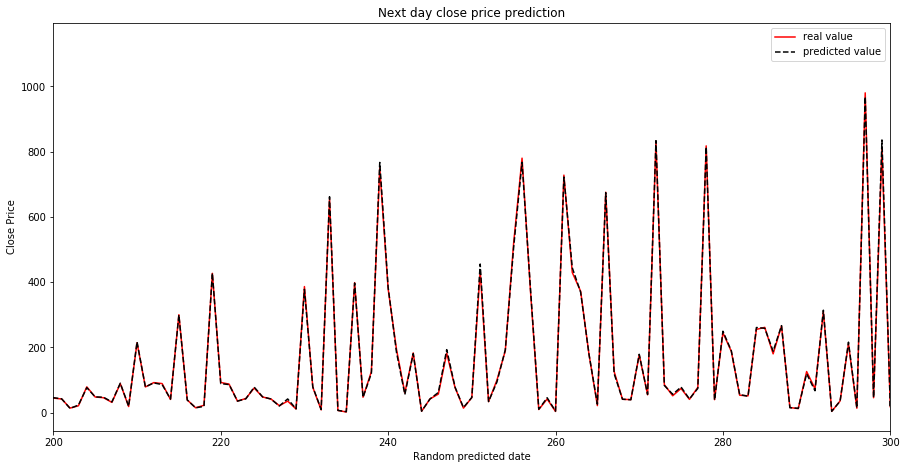

In [31]:
plt:.p.import[`matplotlib]`:pyplot

plt[`:close][]`;
plt[`:figure][`figsize pykw (15 7.5)]`;
plt[`:title][`$"Next day close price prediction"];
plt[`:plot][dict2[`ytest];"r";`label pykw `$"real value"]`;
plt[`:plot][pred2;"k--";`label pykw `$"predicted value"]`;
plt[`:legend][]`;
plt[`:xlim][200;300]`;
plt[`:xlabel]["Random predicted date"];
plt[`:ylabel]["Close Price"];
plt[`:show][]`;


## Conclusions

Multiple runs of the above fit and results sections give an indication both of the usefulness of this form of analysis and the difficultly which is posed in the prediction of stock information. 

In the majority of cases it is seen that the mean squared error decreases in the order 

1. Untreated Data
2. Extracted Features without significance testing
3. Extracted Features with significance testing
4. Yesterday's price = Today's price

However depending on how the data is split by the traintestsplit function large variations in the the mean squared error can occur. This relates to the inclusion or omission of specific events which would cause large errors in prediction such as issues with the global economy or issues with staff. It can also have a detrimental effect on the order which is seen above with variations in this order possible if the features extracted from the split data are not truely indicative of the behaviour of the system.

---